In [1]:
# Initial imports
!pip install alpaca-trade-api
!pip install finta
import pandas as pd
import alpaca_trade_api as tradeapi
from finta import TA
import numpy as np


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
# API credentials
ALPACA_API_KEY = 'PKETI0Q5C8PPUXVNHJFJ'
ALPACA_SECRET_KEY = 'WQxmEpBCoMXydCCg0G8cUe6hGLpgaAfrvedZ09Fy'
ALPACA_API_BASE_URL = "https://paper-api.alpaca.markets"

# Create a connection to the API 
api = tradeapi.REST(ALPACA_API_KEY, ALPACA_SECRET_KEY, ALPACA_API_BASE_URL, api_version="v2")

# Set signal variable
signal = 1

# Create buy signal, num shares and ticker
if signal == 1:
    orderSide = "buy"
else:
    orderSide = "sell"
    
# Set the ticket symbol and the number of shares to buy
ticker = "TSLA"
number_of_shares = 1

# Make API call
prices = api.get_bars(ticker, "5Min", "2022-08-22", "2022-10-14", adjustment='raw').df
# Reorganize the DataFrame
prices = pd.concat([prices], axis=1, keys=["TSLA"])

# Drop the Multi-Index from the DataFrame
prices.columns = prices.columns.droplevel(0)
# create a seperate dataframe for signals
signals_df = prices
signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-08-22 05:55:00+00:00,884.50,884.50,884.50,884.50,105,3,884.504762
2022-08-22 08:00:00+00:00,875.95,877.95,867.99,867.99,19561,1203,872.356079
2022-08-22 08:05:00+00:00,868.33,871.00,868.33,870.50,20461,923,870.052425
2022-08-22 08:10:00+00:00,870.10,870.60,869.00,870.60,7189,480,869.877215
2022-08-22 08:15:00+00:00,869.11,871.00,869.00,871.00,7821,545,870.159190
...,...,...,...,...,...,...,...
2022-10-14 23:35:00+00:00,204.50,204.50,204.17,204.42,10743,340,204.383027
2022-10-14 23:40:00+00:00,204.40,204.71,204.30,204.32,11217,393,204.469150
2022-10-14 23:45:00+00:00,204.32,204.65,204.31,204.35,7935,419,204.405887


In [85]:
# Calculate the daily returns using the closing prices and the pct_change function
signals_df["actual_returns"] = signals_df["close"].pct_change()
signals_df= signals_df.dropna()
signals_df.head()

,open,high,low,close,volume,trade_count,vwap,actual_returns
timestamp,,,,,,,,
2022-08-22 08:10:00+00:00,870.10,870.60,869.0,870.6,7189,480,869.877215,0.000115
2022-08-22 08:15:00+00:00,869.11,871.00,869.0,871.0,7821,545,870.159190,0.000459
2022-08-22 08:20:00+00:00,871.07,871.90,871.0,871.8,3751,268,871.208325,0.000918
2022-08-22 08:25:00+00:00,870.25,870.25,870.0,870.0,3624,282,870.160924,-0.002065
2022-08-22 08:30:00+00:00,870.06,870.20,869.0,869.0,5496,344,869.505364,-0.001149


In [86]:
#  Setup EMAs for crosses
signals_df["9EMA"] = TA.EMA(signals_df, 9)
signals_df["20EMA"] = TA.EMA(signals_df, 20)
signals_df["50EMA"] = TA.EMA(signals_df, 50)
signals_df["200SMA"] = TA.SMA(signals_df, 200)

# Setup Indicators
signals_df["ATR"] = TA.ATR(signals_df)
bbands_df = TA.BBANDS(signals_df)
macd_df = TA.MACD(signals_df)
signals_df["OBV"] = TA.OBV(signals_df)
signals_df["RSI"] = TA.RSI(signals_df)

# join macd and bbands Dataframes to signals_df
bbands_df = pd.concat([bbands_df, macd_df], axis=1)
signals_df = pd.concat([signals_df, bbands_df], axis=1)
signals_df.drop(columns="SIGNAL", inplace=True)
signals_df

# Position Relative to BollingerBands, Above Upper_BB = 1, Below Lower_BB = -1, Inbetween both = 0
signals_df["Bollinger_Bands_Position"] = 0.0
# 9EMA is above 20EMA = 1
signals_df["9EMA/20EMA_Cross"] = 0.0
# 50 EMA is above 200SMA = 1
signals_df["50EMA/200SMA_Cross"] = 0.0
# MACD Increasing = 1, Decreasing = -1
signals_df["MACD_Rate"] = 0.0
# If RSI is above 70: +1, If RSI below 30: -1
signals_df["RSI_Position"] = 0.0
# Price is crossing above VWAP = 1
signals_df["VWAP_Cross"] = 0.0

# Review DataFrame
signals_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,open,high,low,close,volume,trade_count,vwap,actual_returns,9EMA,20EMA,...,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Bollinger_Bands_Position,9EMA/20EMA_Cross,50EMA/200SMA_Cross,MACD_Rate,RSI_Position,VWAP_Cross
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-08-22 08:10:00+00:00,870.10,870.60,869.0,870.6,7189,480,869.877215,0.000115,870.600000,870.600000,...,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-22 08:15:00+00:00,869.11,871.00,869.0,871.0,7821,545,870.159190,0.000459,870.822222,870.810000,...,NaN,NaN,NaN,0.008974,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-22 08:20:00+00:00,871.07,871.90,871.0,871.8,3751,268,871.208325,0.000918,871.222951,871.173522,...,NaN,NaN,NaN,0.036243,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-22 08:25:00+00:00,870.25,870.25,870.0,870.0,3624,282,870.160924,-0.002065,870.808672,870.834744,...,NaN,NaN,NaN,-0.017231,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-22 08:30:00+00:00,870.06,870.20,869.0,869.0,5496,344,869.505364,-0.001149,870.270633,870.390935,...,NaN,NaN,NaN,-0.085718,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
# here we create the exit column, our "y", for use in supervised ML
# How many rows are in the signals_df? for use in modifying DataFrame
periods = signals_df.shape[0]
# Exit is the labeled target for ML, Exit Price is for use in Pnl Metrics
signals_df["Exit"] = 0
signals_df["Exit Price"] = 0

# Exit is the labeled target for ML, Exit Price is for use in Pnl Metrics
signals_df["Exit"] = 0
signals_df["Exit Price"] = 0

# we also figure out our exit price
# target price signaling a win will be 1
# stop price signaling a loss will be -1
# loop thru the dataframe, from row 200 to the end (periods)
for j in range(200, periods):
    # entries will be on candle close
    entry = signals_df["close"].iloc[j]
    # calculate volatility for each candle
    atr = signals_df["ATR"].iloc[j]
    # stop is entry price minus the average volatility for the entry period
    stop = entry - atr
    # target is entry price plus the average volatility for the entry period times a multiplier
    target = entry + (3 * atr)
    # loop again thru the dataset to compare j entry price to future closing prices to see if we hit target or stop
    for k in range(j + 1, periods):
        # current low of the candle
        curr_low = signals_df["low"].iloc[k]
        # current high of the candle
        curr_high = signals_df["high"].iloc[k]
        # record and break if we hit stop or target, if not we check the next k period
        # if current low breaks our stop we should've sold: -1 in our "Exit" column
        if curr_low <= stop:
            signals_df["Exit Price"].iloc[j] = stop
            signals_df["Exit"].iloc[j] = -1
            # if we hit the stop break the inner loop to check the next row
            break
        # if current high breaks our target we should've sold: +1 in our "Exit" column
        elif curr_high >= target:
            signals_df["Exit Price"].iloc[j] = target
            signals_df["Exit"].iloc[j] = 1
            # if we hit the target break the inner loop to check the next row
            break

# drop beginning columns to avoid NaN values from EMA/SMA calculations
signals_df = signals_df[200:]

signals_df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,open,high,low,close,volume,trade_count,vwap,actual_returns,9EMA,20EMA,...,BB_LOWER,MACD,Bollinger_Bands_Position,9EMA/20EMA_Cross,50EMA/200SMA_Cross,MACD_Rate,RSI_Position,VWAP_Cross,Exit,Exit Price
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-08-23 09:55:00+00:00,877.80,877.80,877.80,877.80,593,40,877.908482,0.000912,876.825144,876.064473,...,874.719485,1.112717,0.0,0.0,0.0,0.0,0.0,0.0,-1,876.994286
2022-08-23 10:00:00+00:00,878.10,878.10,877.59,877.59,3081,129,877.867299,-0.000239,876.978115,876.209761,...,874.875813,1.104058,0.0,0.0,0.0,0.0,0.0,0.0,-1,876.776429
2022-08-23 10:05:00+00:00,877.18,877.18,877.00,877.00,1722,127,877.101464,-0.000672,876.982492,876.285022,...,874.876445,1.037627,0.0,0.0,0.0,0.0,0.0,0.0,-1,876.181429
2022-08-23 10:10:00+00:00,877.18,877.18,877.18,877.18,660,19,877.178225,0.000205,877.021994,876.370258,...,874.943433,0.988113,0.0,0.0,0.0,0.0,0.0,0.0,-1,876.407857
2022-08-23 10:15:00+00:00,876.00,876.00,876.00,876.00,261,14,876.129693,-0.001345,876.817595,876.334995,...,874.954418,0.843929,0.0,0.0,0.0,0.0,0.0,0.0,-1,875.252143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-14 23:35:00+00:00,204.50,204.50,204.17,204.42,10743,340,204.383027,-0.000391,204.242027,204.233724,...,203.935367,-0.083409,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
2022-10-14 23:40:00+00:00,204.40,204.71,204.30,204.32,11217,393,204.469150,-0.000489,204.257621,204.241941,...,203.939980,-0.069355,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
2022-10-14 23:45:00+00:00,204.32,204.65,204.31,204.35,7935,419,204.405887,0.000147,204.276097,204.252232,...,203.944737,-0.055160,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000


In [88]:
# check if there is potentially-unwanted zeros in the dataframe
signals_df["Exit"].value_counts()

-1    5474
 1    1870
 0      20
Name: Exit, dtype: int64

In [89]:
# Remove all unwanted zeros from the exit column
signals_df = signals_df.loc[signals_df["Exit"] != 0]
signals_df["Exit"].value_counts()

-1    5474
 1    1870
Name: Exit, dtype: int64

In [90]:
# choose if you want continuous or discrete features
continuous_features = ["volume", "trade_count", "vwap", "9EMA", "20EMA", "50EMA", "200SMA", "ATR", "RSI", "BB_UPPER", "BB_MIDDLE", "BB_LOWER", "MACD"]
X = signals_df[continuous_features]

# 1 means a buy would've produced a profit, -1 means a short would've produced a profit
y = signals_df["Exit"]
#signals_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# X
X

,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD
timestamp,,,,,,,,,,,,,
2022-08-23 09:55:00+00:00,593,40,877.908482,876.825144,876.064473,873.839715,869.796807,0.805714,63.155223,879.373515,877.0465,874.719485,1.112717
2022-08-23 10:00:00+00:00,3081,129,877.867299,876.978115,876.209761,873.986831,869.829756,0.813571,61.693281,879.397187,877.1365,874.875813,1.104058
2022-08-23 10:05:00+00:00,1722,127,877.101464,876.982492,876.285022,874.105030,869.855756,0.818571,57.655186,879.397555,877.1370,874.876445,1.037627
2022-08-23 10:10:00+00:00,660,19,877.178225,877.021994,876.370258,874.225651,869.891657,0.772143,58.546650,879.161567,877.0525,874.943433,0.988113
2022-08-23 10:15:00+00:00,261,14,876.129693,876.817595,876.334995,874.295252,869.926657,0.747857,50.970989,878.851582,876.9030,874.954418,0.843929
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-14 23:10:00+00:00,5787,316,204.106401,204.131088,204.207023,205.169425,214.027420,0.179286,42.426420,204.402228,204.0615,203.720772,-0.184282
2022-10-14 23:15:00+00:00,6314,345,204.160509,204.144870,204.206355,205.131408,213.942420,0.178571,45.790482,204.405371,204.0810,203.756629,-0.165547
2022-10-14 23:20:00+00:00,4710,269,204.157003,204.139896,204.198130,205.091745,213.856420,0.176429,43.595855,204.408974,204.0845,203.760026,-0.155364


In [91]:
# check for potentially unwanted zeros
signals_df["Exit"].value_counts()
signals_df = signals_df.dropna()
signals_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7194 entries, 2022-08-23 09:55:00+00:00 to 2022-10-14 23:30:00+00:00
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   open                      7194 non-null   float64
 1   high                      7194 non-null   float64
 2   low                       7194 non-null   float64
 3   close                     7194 non-null   float64
 4   volume                    7194 non-null   int64  
 5   trade_count               7194 non-null   int64  
 6   vwap                      7194 non-null   float64
 7   actual_returns            7194 non-null   float64
 8   9EMA                      7194 non-null   float64
 9   20EMA                     7194 non-null   float64
 10  50EMA                     7194 non-null   float64
 11  200SMA                    7194 non-null   float64
 12  ATR                       7194 non-null   float64
 13  OBV            

In [92]:
#import Dateoffset library
from pandas.tseries.offsets import DateOffset

In [102]:
#select training start date
training_begin = X.index.min()
training_begin
#select training end date
training_end = training_begin + DateOffset( days = 15)
training_end

Timestamp('2022-09-07 09:55:00+0000', tz='UTC')

In [103]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]
y_train[:5]
y_train.replace([np.inf, -np.inf], np.nan, inplace=True)


In [104]:
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]
np.unique(y_test)
#X_test.head()

array([-1,  1])

In [105]:
# Import required libraries
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [106]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_test_scaled[:5]

array([[-0.62920913, -0.6655078 , -0.49164003, -0.49698186, -0.5041325 ,
        -0.52425045, -0.60948322, -0.26426534,  0.43948239, -0.50770051,
        -0.50199226, -0.47354243,  0.15353244],
       [-0.63110047, -0.67059628, -0.49205505, -0.496923  , -0.5040727 ,
        -0.52417007, -0.60944846, -0.26739368,  0.39502198, -0.50772221,
        -0.50201149, -0.47355824,  0.15322427],
       [-0.62721657, -0.6640305 , -0.49156245, -0.49679866, -0.50398185,
        -0.52407774, -0.60941081, -0.26270117,  0.46929734, -0.50769894,
        -0.50199012, -0.4735398 ,  0.15334908],
       [-0.62982448, -0.6728943 , -0.49124921, -0.49673352, -0.50391598,
        -0.52399575, -0.60935991, -0.26582951,  0.42910785, -0.50769438,
        -0.50198585, -0.47353602,  0.15313104],
       [-0.62950748, -0.66747753, -0.49321391, -0.49705051, -0.50403194,
        -0.52398906, -0.60933447, -0.2648519 ,  0.02034484, -0.50768147,
        -0.50209058, -0.4737587 ,  0.15060489]])

#SGD Classifier

In [107]:
#Create the classifier model
SGD_model = SGDClassifier()
# Fit the model to the data using X_train_scaled and y_train
SGD_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
SGD_training_predictions = SGD_model.predict(X_train_scaled)

# Display the sample predictions
SGD_training_predictions[:5]

array([-1, -1, -1, -1, -1])

In [108]:
SGD_training_report = classification_report(y_train, SGD_training_predictions)
print(SGD_training_report)

              precision    recall  f1-score   support

          -1       0.77      1.00      0.87      1466
           1       0.59      0.02      0.04       448

    accuracy                           0.77      1914
   macro avg       0.68      0.51      0.46      1914
weighted avg       0.73      0.77      0.67      1914



In [109]:
# Fit the model to the  test data using X_test_scaled and y_test
SGD_model.fit(X_test_scaled, y_test)

# Use the trained model to predict the trading signals for the training data
SGD_test_predictions = SGD_model.predict(X_test_scaled)

# Display the sample predictions
SGD_test_predictions[50:]

array([-1, -1, -1, ..., -1, -1, -1])

In [110]:
SGD_testing_report = classification_report(y_test, SGD_test_predictions)
print(SGD_testing_report)

              precision    recall  f1-score   support

          -1       0.74      1.00      0.85      4009
           1       0.00      0.00      0.00      1422

    accuracy                           0.74      5431
   macro avg       0.37      0.50      0.42      5431
weighted avg       0.54      0.74      0.63      5431



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
# Create a new empty predictions DataFrame using code provided below.
SGD_predictions_df = pd.DataFrame(index=X_test.index)
SGD_predictions_df["predicted_signal"] = SGD_test_predictions
SGD_predictions_df["actual_returns"] = signals_df["actual_returns"]
SGD_predictions_df["trading_algorithm_returns"] = SGD_predictions_df["actual_returns"] * SGD_predictions_df["predicted_signal"]
SGD_predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
timestamp,,,
2022-09-07 09:55:00+00:00,-1,-0.000145,0.000145
2022-09-07 10:15:00+00:00,-1,-0.000182,0.000182
2022-09-07 10:20:00+00:00,-1,0.000327,-0.000327
2022-09-07 10:25:00+00:00,-1,-0.000145,0.000145
2022-09-07 10:30:00+00:00,-1,-0.001564,0.001564


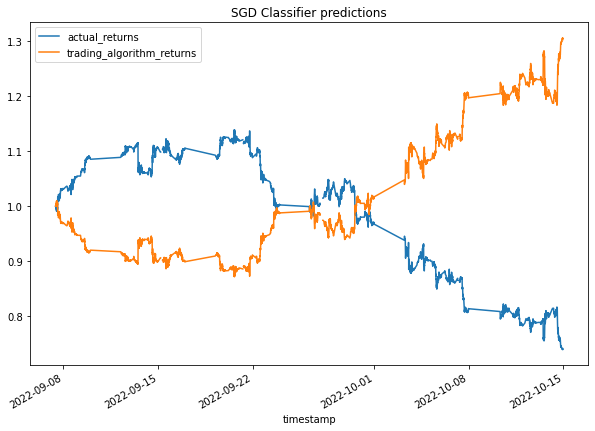

In [112]:
SGD_training_predictions # Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + SGD_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(figsize = (10,7), title = 'SGD Classifier predictions')